# Dataset S-VED

In [294]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
import urllib.request
from PIL import Image, ImageDraw
import torchvision.transforms as T

import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from engine import train_one_epoch, evaluate

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


# Dataset creation

In [274]:
class SVED_Dataset(Dataset):
    def __init__(self):
        self.root = "dataset"
        self.transforms = None
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("dataset")))
        self.mask = pd.read_csv("SVED.csv")
        self.labeling = {'Initial': 0, 'Decoration':1, 'ContentIllustration': 2, 'PrintersMark': 3}
        self.num_classes = 5

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255
        # img = Image.open(img_path).convert("RGB")

        obj_ids = self.mask[self.mask['image'] == str(idx) + '.jpg']

        # get bounding box coordinates for each mask
        len_mask = len(obj_ids)
        boxes, labels = torch.zeros(size=(len_mask, 4)), []
        for i in range(len_mask):
            pos = obj_ids.iloc[i]
            xmin = pos['x']
            xmax = pos['x'] + pos['width']
            ymin = pos['y']
            ymax = pos['y'] + pos['height']
            boxes[i] = torch.as_tensor([xmin, ymin, xmax, ymax])

            label = self.labeling[pos['label']]
            labels.append(label)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

def collate_fn(batch):
        images = []
        targets = []
        for img, target in batch:
            images.append(T.ToTensor()(img))
            targets.append(target)
        return images, targets

# def collate_fn(batch):
#         images = []
#         targets = []
#         for k, (img, target) in enumerate(batch):
#             images.append(T.ToTensor()(img))
#             targets.append(target)
#         return images, targets


In [282]:
class SVED_Dataset(Dataset):

    def __init__(self, files_dir, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.data = pd.read_csv("SVED_RCNN.csv", index_col=[0])
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']


        # classes: 0 index is reserved for background
        self.classes = {'_': '0', 'Initial': 1, 'Decoration': 2, 'ContentIllustration': 3, 'PrintersMark': 4}
        self.num_classes = len(self.classes)
        self.data['label'].replace(self.classes, inplace=True)

    def __getitem__(self, idx):

        # annotation file
        data_img = self.data[self.data['image'] == str(idx) + '.jpg']
        # annot_file_path = os.path.join(self.files_dir, annot_filename)

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)

        # width and heights parameters
        width, height = img.shape[:-1]

        # Preprocessing of the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (width, height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        boxes = []
        labels = []

        # box coordinates for xml files are extracted and corrected for image size given
        for index, row in data_img.iterrows():
            xmin = row['x'] * width
            xmax = (row['x'] + row['width']) * width
            ymin = row['y'] * height
            ymax = (row['y'] + row['height']) * height
            boxes.append([xmin, ymin, xmax, ymax])

            label = row['label']
            labels.append(label)

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = SVED_Dataset("dataset")
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
print(img.shape, '\n',target)

length of dataset =  1928 

(996, 1278, 3) 
 {'boxes': tensor([[615.9036, 748.9484, 964.9156, 894.6854],
        [608.2048, 593.8591, 923.8554, 768.4319]]), 'labels': tensor([3, 3]), 'area': tensor([50863.9883, 55104.0078]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}


# Training Faster-RCNN

In [276]:
# define the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the parameters for training
num_epochs = 40
batch_size = 1
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.005

# create the dataset and dataloader
dataset = SVED_Dataset("dataset") # replace with your custom dataset
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

#Hyperparameters for dataloader
validation_split = .3
shuffle_dataset = True
random_seed = 42

# déterminer les index de division entre train/val
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# créer les samplers à partir des index
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# créer les dataloaders avec les samplers
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=valid_sampler, collate_fn=collate_fn)

# load a pre-trained Faster R-CNN model from the torchvision model zoo
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.train()

# replace the pre-trained classifier with a new one that has the correct number of classes
num_classes = dataset.num_classes  # replace with the number of classes in your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move the model to the device
model.to(device)

# define the optimizer and the learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# train the model for the specified number of epochs
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=300)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, validation_loader, device=device)

print("Training completed!")
torch.save(model, 'my_weights/faster_rcnn.pkl')

Epoch: [0]  [   0/1350]  eta: 0:12:05  lr: 0.000010  loss: 3.3670 (3.3670)  loss_classifier: 1.4892 (1.4892)  loss_box_reg: 0.0021 (0.0021)  loss_objectness: 1.6956 (1.6956)  loss_rpn_box_reg: 0.1801 (0.1801)  time: 0.5374  data: 0.1860  max mem: 4174
Epoch: [0]  [ 300/1350]  eta: 0:09:19  lr: 0.001508  loss: 0.1063 (0.2731)  loss_classifier: 0.0327 (0.1249)  loss_box_reg: 0.0236 (0.0418)  loss_objectness: 0.0174 (0.0819)  loss_rpn_box_reg: 0.0052 (0.0245)  time: 0.5170  data: 0.1602  max mem: 4501
Epoch: [0]  [ 600/1350]  eta: 0:06:36  lr: 0.003007  loss: 0.1018 (0.2362)  loss_classifier: 0.0349 (0.0892)  loss_box_reg: 0.0260 (0.0461)  loss_objectness: 0.0135 (0.0732)  loss_rpn_box_reg: 0.0063 (0.0278)  time: 0.4924  data: 0.1428  max mem: 4501
Epoch: [0]  [ 900/1350]  eta: 0:03:55  lr: 0.004505  loss: 0.1083 (0.2146)  loss_classifier: 0.0454 (0.0797)  loss_box_reg: 0.0512 (0.0502)  loss_objectness: 0.0102 (0.0600)  loss_rpn_box_reg: 0.0060 (0.0246)  time: 0.5044  data: 0.1526  max me

KeyboardInterrupt: 

In [277]:
def prediction_faster_rcnn(image_path):
    #image loading
    model.eval()
    transform = T.ToTensor()
    try:
        image = Image.open(image_path)
    except:
        urllib.request.urlretrieve(image_path, "image.jpg")
        image = Image.open("image.jpg")

    #prediction
    tensor_image = transform(image).unsqueeze(0).to(device)
    prediction = model(tensor_image)

    #list of boxes and labels
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    keep = torchvision.ops.nms(boxes, scores, .1)
    print(boxes, labels)

    for (box, label) in zip(boxes[keep], labels[keep]):
        rectangle_box = [(box[0], box[1]), (box[2], box[3])]
        rectangle_label = categories[label.item()]

        img_box = ImageDraw.Draw(image)
        img_box.rectangle(rectangle_box, outline="red")
        img_box.text(rectangle_box[1], text=rectangle_label, fill="red")

    return image

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>) tensor([], device='cuda:0', dtype=torch.int64)


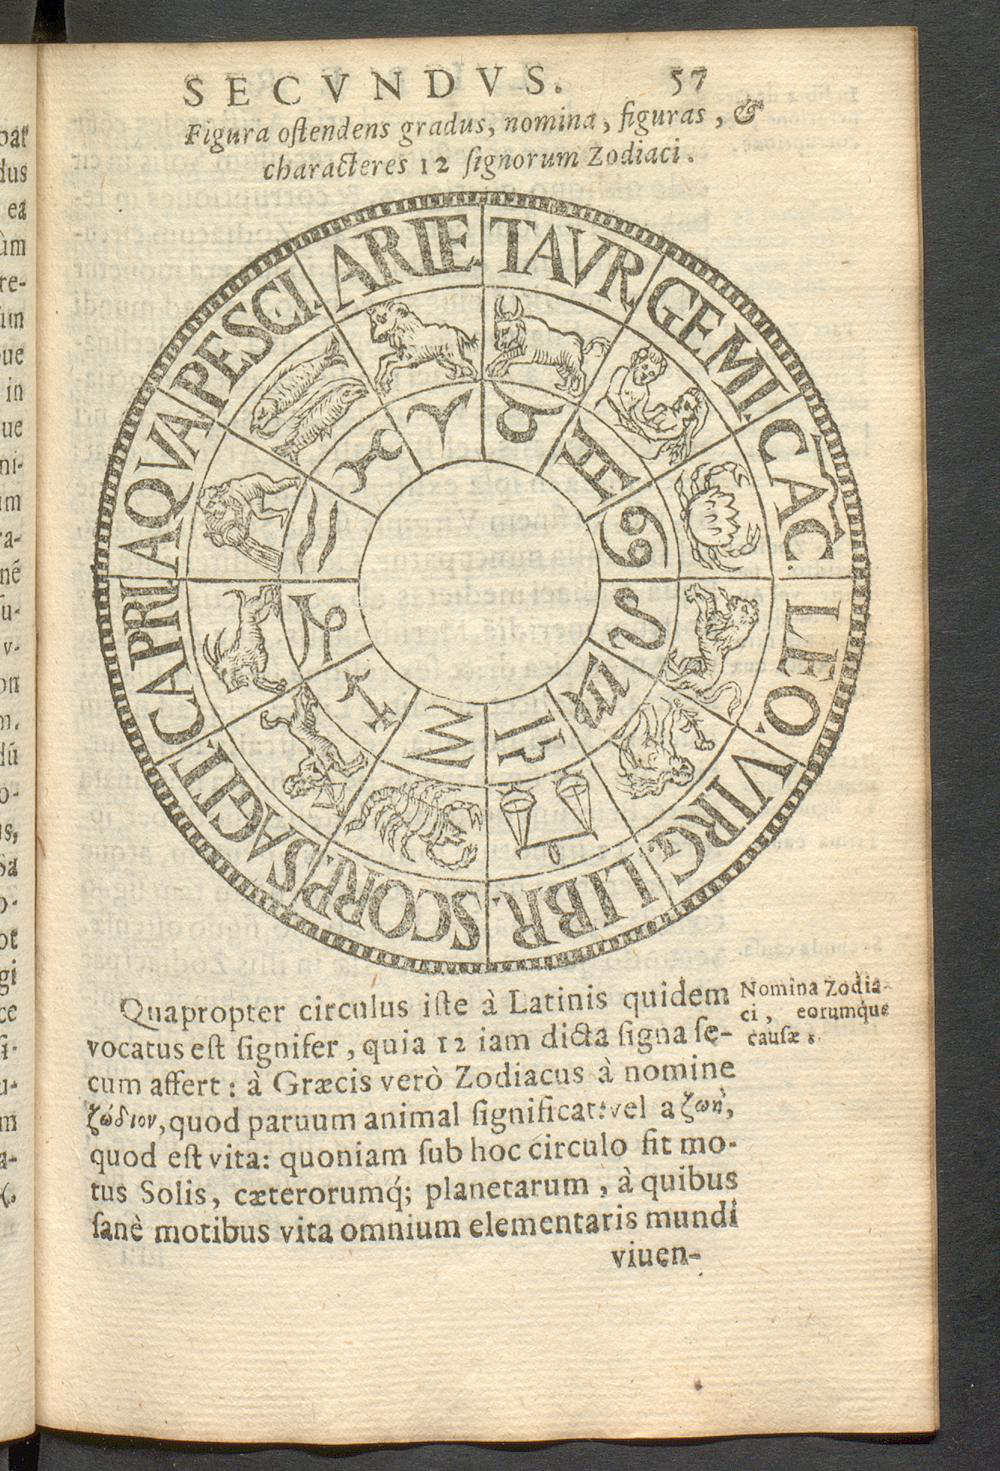

In [278]:
prediction_faster_rcnn('dataset/1015.jpg')

# Faster-RCNN

In [30]:
import torch
import torchvision
from PIL import Image, ImageDraw

In [31]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [32]:
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Définir les transformations à appliquer aux images
transform = Compose([Resize((800, 800)), ToTensor()])

# Charger le dataset COCO
coco_train_dataset = CocoDetection(root='coco/images/train2017',
                                   annFile='coco/annotations/instances_val2017.json',
                                   transform=transform)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [42]:
# Définir le modèle Faster R-CNN pré-entraîné
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

# Code pour Remplacer le prédicteur de classification par défaut pour le nombre de classes dans le dataset COCO
# num_classes = 91 # 90 classes d'objets + 1 classe pour l'arrière-plan
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Définir le dataloader pour le dataset
dataloader = torch.utils.data.DataLoader(coco_train_dataset, batch_size=4, shuffle=True)

In [43]:
import json

# Charger le fichier d'annotations COCO
with open('coco/annotations/instances_val2017.json', 'r') as f:
    coco_data = json.load(f)

# Créer un dictionnaire d'étiquettes pour le jeu de données COCO
categories = {}
for cat in coco_data['categories']:
    categories[cat['id']] = cat['name']

In [44]:
def prediction_faster_rcnn(image_path):
    #image loading
    try:
        image = Image.open(image_path)
    except:
        urllib.request.urlretrieve(image_path,"image.jpg")
        image = Image.open("image.jpg")

    #data pre-processing
    image = image.resize((800, 800))
    tensor_image = transform(image)
    tensor_image = tensor_image.unsqueeze(0)

    #prediction
    prediction = faster_rcnn(tensor_image)

    #list of boxes and labels
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    keep = torchvision.ops.nms(boxes, scores, .1)

    for (box, label) in zip(boxes[keep], labels[keep]):
        rectangle_box = [(box[0], box[1]), (box[2], box[3])]
        rectangle_label = categories[label.item()]

        img_box = ImageDraw.Draw(image)
        img_box.rectangle(rectangle_box, outline="red")
        img_box.text(rectangle_box[1], text=rectangle_label, fill="red")

    return image

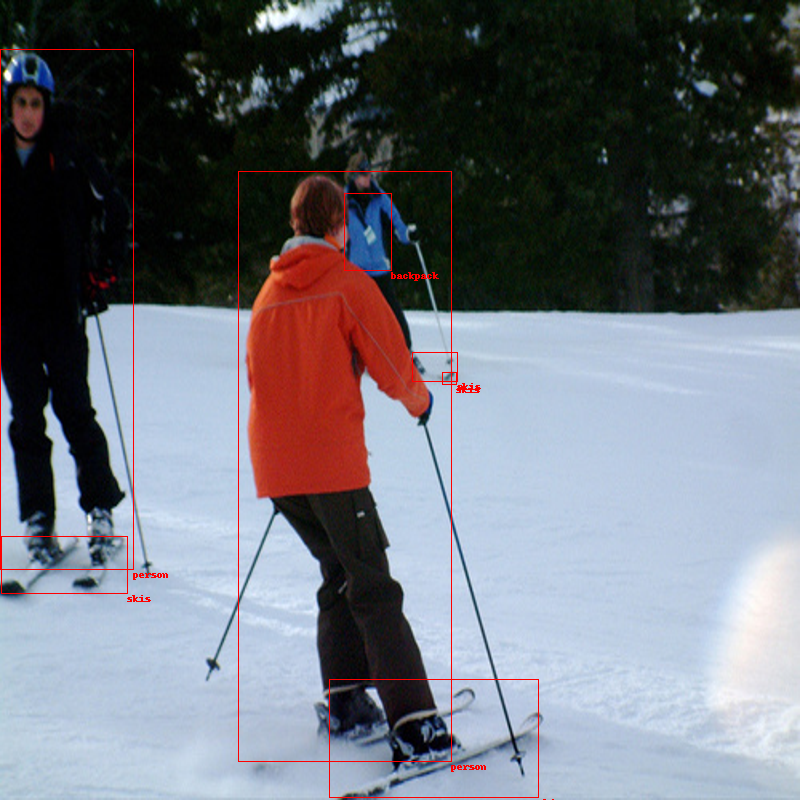

In [45]:
prediction_faster_rcnn('coco/images/train2017/000000366326.jpg')

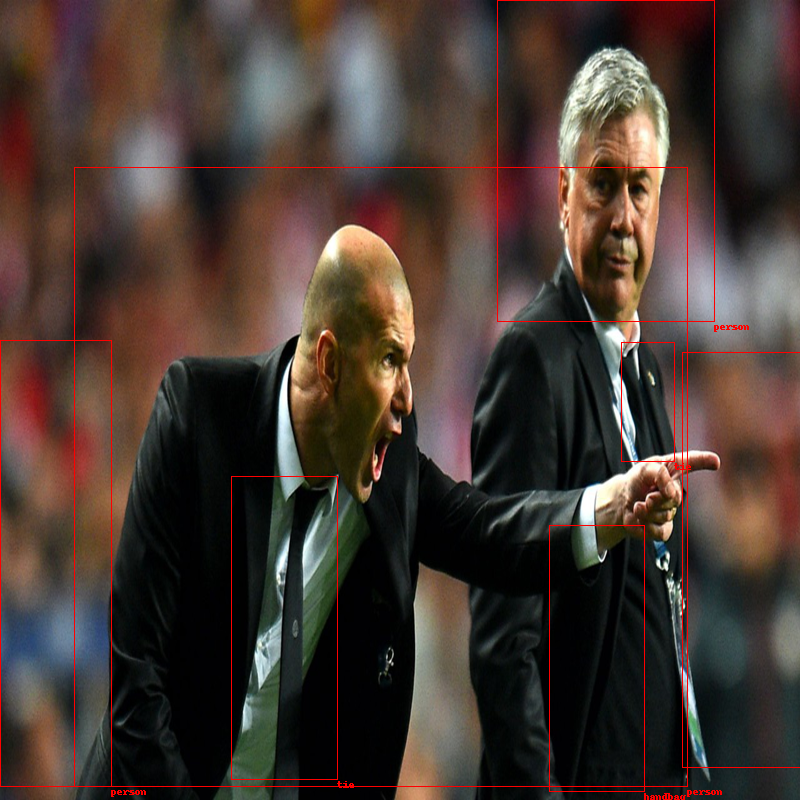

In [46]:
prediction_faster_rcnn('https://ultralytics.com/images/zidane.jpg')

In [303]:
data  = pd.read_csv("SVED.csv")
data['file'] = data['image']

for file in os.listdir("dataset"):
    if file not in data['file'].unique():
        try:
            os.remove(file)
        except:
            pass

In [304]:
i = 0
already = []
for index, row in data.iterrows():
    if row['image'] not in already:
        already.append(row['image'])
        already.append( str(i)+'.jpg')
        data.loc[data['image']==row['image'], 'image'] = str(i)+'.jpg'
        i += 1


data

image                label         x         y     width    height  \
0        0.jpg  ContentIllustration  0.481928  0.751956  0.273092  0.146322   
1        0.jpg  ContentIllustration  0.475904  0.596244  0.246988  0.175274   
2        1.jpg  ContentIllustration  0.591880  0.435120  0.636752  0.407616   
3        2.jpg  ContentIllustration  0.372033  0.543175  0.189224  0.235177   
4        3.jpg              Initial  0.276238  0.134523  0.113452  0.180402   
...        ...                  ...       ...       ...       ...       ...   
2922  1959.jpg  ContentIllustration  0.609000  0.431655  0.675000  0.453891   
2923  1960.jpg           Decoration  0.403277  0.408863  0.107294  0.075768   
2924  1961.jpg  ContentIllustration  0.513105  0.477770  0.963710  0.814864   
2925  1962.jpg  ContentIllustration  0.410000  0.283682  0.340667  0.321921   
2926  1962.jpg  ContentIllustration  0.416667  0.728324  0.321333  0.261005   

          file  
0     1002.jpg  
1     1002.jpg  
2     1003.jpg  
3     1004.jpg  
4     1005.jpg  
...        ...  
2922  4993.jpg  
2923  4994.jpg  
2924  4998.jpg  
2925  4999.jpg  
2926  4999.jpg  

[2927 rows x 7 columns]

In [306]:
data.to_csv("SVED_RCNN.csv")

OSError: [Errno 28] No space left on device